In [1]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import MeanAbsolutePercentageError
from datetime import datetime, timedelta
rdseed = 123
def set_all_seeds(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
set_all_seeds(rdseed)

d:\Anaconda3\envs\DLinear\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
d:\Anaconda3\envs\DLinear\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
d:\Anaconda3\envs\DLinear\lib\site-packages\torchaudio\backend\utils.py:89: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [2]:
# DLinear模型
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, seq_len, pred_len, kernel_size):
        super(DLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len

        # Decompsition Kernel Size
        self.decompsition = series_decomp(kernel_size)

        self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
        self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
        
        # Use this two lines if you want to visualize the weights
        # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
 
        seasonal_output = self.Linear_Seasonal(seasonal_init)

        trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

In [3]:
class Dataset_Custom(Dataset):
    def __init__(self, df, seq_len, pred_len):
        self.df = df
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __getitem__(self, index):
        # input
        input_begin = index
        input_end = input_begin + self.seq_len

        # label
        label_begin = input_end
        label_end = label_begin + self.pred_len

        seq_x = self.df[input_begin:input_end]
        seq_y = self.df[label_begin:label_end]

        return seq_x, seq_y

    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len + 1

def shift_date_24(start_date, days_to_shift):
    # 将字符串格式日期转换为 datetime 对象
    date_obj = datetime.strptime(start_date, '%Y-%m-%d')
    
    # 向后推移指定天数
    shifted_date = date_obj + timedelta(days=days_to_shift)
    
    # 将结果转换为字符串格式并返回
    shifted_date_str = shifted_date.strftime('%Y-%m-%d')
    return shifted_date_str
# 重新初始化模型的权重
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()


In [4]:
tickers = ['IAI', 'IVV', 'ESGU', 'PICK', 'QUAL', 'SLV', 'IWB', 'HEWJ', 'RING', 'IAU', 'IYY', 'EWT', 'ITOT', 'IWV', 'IAK', 'ILCB', 'DIVB', 'ICVT', 'DGRO', 'IFRA']

IAI


100%|██████████| 200/200 [00:00<00:00, 209.80it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


IAI:          date       Open       High        Low      Close  Adj Close  Volume  \
317 2021-01-04  80.629997  80.629997  78.290001  79.160004  74.832153  110400   
318 2021-01-05  79.099998  80.029999  78.239998  79.669998  75.314270   28500   
319 2021-01-06  80.699997  84.580002  80.699997  83.959999  79.369713  227400   
320 2021-01-07  84.949997  86.080002  84.949997  85.610001  80.929512   31700   
321 2021-01-08  85.739998  85.739998  84.639999  85.739998  81.052399   27500   

       Return  
317  1.282566  
318  1.290829  
319  1.360337  
320  1.387071  
321  1.389177  
IVV


100%|██████████| 200/200 [00:00<00:00, 213.97it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


IVV:          date        Open        High         Low       Close   Adj Close  \
317 2021-01-04  376.690002  376.820007  366.160004  370.220001  353.925385   
318 2021-01-05  369.440002  373.829987  369.440002  372.670013  356.267670   
319 2021-01-06  371.019989  378.369995  370.459991  374.920013  358.418518   
320 2021-01-07  377.470001  381.260010  377.279999  380.470001  363.724304   
321 2021-01-08  382.010010  382.859985  378.489990  382.640015  365.798798   

      Volume    Return  
317  7103700  1.255366  
318  4310500  1.263674  
319  4343100  1.271303  
320  6051700  1.290122  
321  3400200  1.297481  
ESGU


100%|██████████| 200/200 [00:00<00:00, 204.29it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


ESGU:          date       Open       High        Low      Close  Adj Close  Volume  \
317 2021-01-04  86.419998  86.419998  83.949997  84.889999  81.345375  878200   
318 2021-01-05  84.809998  85.669998  84.647003  85.489998  81.920319  863600   
319 2021-01-06  85.089996  86.720001  84.900002  85.940002  82.351532  669800   
320 2021-01-07  86.559998  87.449997  86.519997  87.300003  83.654747  556400   
321 2021-01-08  87.760002  87.879997  86.860001  87.860001  84.191368  606500   

       Return  
317  1.311650  
318  1.320921  
319  1.327874  
320  1.348888  
321  1.357540  
PICK


100%|██████████| 200/200 [00:00<00:00, 213.65it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


PICK:          date       Open       High        Low      Close  Adj Close  Volume  \
317 2021-01-04  38.040001  38.610001  37.770000  37.950001  32.165108  288100   
318 2021-01-05  38.419998  39.000000  38.230000  38.790001  32.877064  358200   
319 2021-01-06  39.790001  40.630001  39.689999  40.279999  34.139935  383900   
320 2021-01-07  41.000000  41.290001  40.770000  41.270000  34.979023  538000   
321 2021-01-08  41.599998  41.599998  40.680000  41.169998  34.894264  251800   

       Return  
317  1.445164  
318  1.477152  
319  1.533892  
320  1.571592  
321  1.567784  
QUAL


100%|██████████| 200/200 [00:00<00:00, 233.90it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


QUAL:          date        Open        High         Low       Close   Adj Close  \
317 2021-01-04  116.419998  116.470001  113.150002  114.360001  109.702461   
318 2021-01-05  113.940002  115.150002  113.940002  114.820000  110.143707   
319 2021-01-06  114.279999  116.230003  114.000000  115.349998  110.652130   
320 2021-01-07  116.019997  116.889999  115.839996  116.650002  111.899170   
321 2021-01-08  117.099998  117.300003  116.059998  117.220001  112.445969   

     Volume    Return  
317  949900  1.253535  
318  719000  1.258577  
319  659200  1.264387  
320  667800  1.278636  
321  831500  1.284884  
SLV


100%|██████████| 200/200 [00:00<00:00, 215.19it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


SLV:          date       Open       High        Low  Close  Adj Close     Volume  \
317 2021-01-04  25.540001  25.610001  24.870001  25.35      25.35   54026000   
318 2021-01-05  25.459999  25.740000  25.280001  25.67      25.67   32882000   
319 2021-01-06  25.340000  25.400000  24.719999  25.34      25.34   54978700   
320 2021-01-07  25.219999  25.370001  25.049999  25.26      25.26   27335800   
321 2021-01-08  24.730000  24.760000  22.740000  23.51      23.51  107226800   

       Return  
317  1.569660  
318  1.589474  
319  1.569040  
320  1.564087  
321  1.455728  
IWB


100%|██████████| 200/200 [00:00<00:00, 208.71it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


IWB:          date        Open        High         Low       Close   Adj Close  \
317 2021-01-04  212.759995  212.990005  206.710007  208.889999  200.452225   
318 2021-01-05  208.559998  211.029999  208.559998  210.529999  202.025955   
319 2021-01-06  209.389999  213.770004  209.380005  211.889999  203.331055   
320 2021-01-07  213.339996  215.610001  213.309998  215.130005  206.440155   
321 2021-01-08  216.169998  216.490005  214.039993  216.419998  207.678040   

      Volume    Return  
317   888800  1.284923  
318   379400  1.295011  
319  1145000  1.303377  
320   580800  1.323307  
321   424600  1.331242  
HEWJ


100%|██████████| 200/200 [00:00<00:00, 212.26it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


HEWJ:          date       Open       High        Low      Close  Adj Close  Volume  \
317 2021-01-04  35.740002  35.740002  35.349998  35.360001  23.779198   53500   
318 2021-01-05  35.400002  35.630001  35.389999  35.540001  23.900246   43200   
319 2021-01-06  35.680000  36.230000  35.680000  36.119999  24.290285   52800   
320 2021-01-07  36.189999  36.330002  36.189999  36.320000  24.424786   38900   
321 2021-01-08  36.860001  37.009998  36.650002  37.009998  24.888803   40000   

       Return  
317  1.142119  
318  1.147933  
319  1.166667  
320  1.173127  
321  1.195413  
RING


100%|██████████| 200/200 [00:00<00:00, 236.73it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


RING:          date       Open       High        Low      Close  Adj Close  Volume  \
317 2021-01-04  31.219999  32.240002  31.100000  32.099998  30.097334  236800   
318 2021-01-05  32.430000  32.430000  31.620001  31.860001  29.872309  195300   
319 2021-01-06  31.590000  32.110001  31.260000  31.990000  29.994196  332300   
320 2021-01-07  32.070000  32.160000  31.620001  32.020000  30.022324  123900   
321 2021-01-08  31.299999  31.459999  30.100000  30.620001  28.709669  284900   

       Return  
317  1.468435  
318  1.457457  
319  1.463403  
320  1.464776  
321  1.400732  
IAU


100%|██████████| 200/200 [00:00<00:00, 239.48it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


IAU:          date       Open       High        Low      Close  Adj Close  \
317 2021-01-04  36.959999  37.099998  36.779999  37.099998  37.099998   
318 2021-01-05  37.180000  37.259998  36.980000  37.180000  37.180000   
319 2021-01-06  36.919998  36.919998  36.240002  36.599998  36.599998   
320 2021-01-07  36.540001  36.580002  36.360001  36.480000  36.480000   
321 2021-01-08  35.959999  36.000000  34.860001  35.259998  35.259998   

       Volume    Return  
317  16074700  1.309104  
318  11376700  1.311927  
319  18060850  1.291461  
320  10712400  1.287227  
321  15582650  1.244178  
IYY


100%|██████████| 200/200 [00:00<00:00, 206.07it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


IYY:          date       Open       High        Low      Close  Adj Close  Volume  \
317 2021-01-04  94.690002  94.709999  92.089996  93.019997  89.401978   66100   
318 2021-01-05  92.779999  93.959999  92.779999  93.739998  90.093956   71300   
319 2021-01-06  93.209999  95.209999  93.209999  94.370003  90.699455   80900   
320 2021-01-07  95.070000  96.040001  95.070000  95.930000  92.198769   65100   
321 2021-01-08  96.370003  96.410004  95.349998  96.400002  92.650505   45000   

       Return  
317  1.277046  
318  1.286930  
319  1.295579  
320  1.316996  
321  1.323449  
EWT


100%|██████████| 200/200 [00:01<00:00, 195.19it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


EWT:          date       Open       High        Low      Close  Adj Close  \
317 2021-01-04  54.169998  54.330002  53.549999  53.779999  41.054344   
318 2021-01-05  54.660000  55.029999  54.590000  54.930000  41.932232   
319 2021-01-06  54.349998  55.029999  54.320000  54.900002  41.909328   
320 2021-01-07  55.509998  55.910000  55.410000  55.869999  42.649799   
321 2021-01-08  56.560001  56.610001  55.910000  56.270000  42.955154   

      Volume    Return  
317  4036600  1.476256  
318  5833600  1.507823  
319  6579600  1.507000  
320  4757900  1.533626  
321  4275500  1.544606  
ITOT


100%|██████████| 200/200 [00:01<00:00, 196.84it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


ITOT:          date       Open       High        Low      Close  Adj Close  \
317 2021-01-04  86.589996  86.629997  84.110001  85.120003  81.390167   
318 2021-01-05  84.919998  86.000000  84.919998  85.760002  82.002129   
319 2021-01-06  85.489998  87.279999  85.370003  86.540001  82.747940   
320 2021-01-07  87.169998  88.050003  87.070000  87.860001  84.010101   
321 2021-01-08  88.250000  88.430000  87.330002  88.279999  84.411705   

      Volume    Return  
317  3729600  1.285412  
318  2234800  1.295077  
319  1776300  1.306856  
320  1109900  1.326789  
321  1341300  1.333132  
IWV


100%|██████████| 200/200 [00:00<00:00, 244.01it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


IWV:          date        Open        High         Low       Close   Adj Close  \
317 2021-01-04  224.470001  224.500000  218.360001  220.589996  211.858521   
318 2021-01-05  220.130005  222.960007  220.130005  222.460007  213.654495   
319 2021-01-06  221.460007  226.410004  221.460007  224.169998  215.296829   
320 2021-01-07  225.649994  228.339996  225.649994  227.839996  218.821564   
321 2021-01-08  228.910004  229.199997  226.520004  229.050003  219.983688   

     Volume    Return  
317  458000  1.286014  
318  844200  1.296916  
319  306100  1.306885  
320  345300  1.328281  
321  235200  1.335335  
IAK


100%|██████████| 200/200 [00:01<00:00, 195.56it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


IAK:          date       Open       High        Low      Close  Adj Close  Volume  \
317 2021-01-04  67.599998  67.599998  65.709999  65.970001  62.269772    4000   
318 2021-01-05  66.199997  66.199997  65.610001  66.040001  62.335842    2000   
319 2021-01-06  68.050003  69.160004  68.010002  69.059998  65.186447    5700   
320 2021-01-07  69.180000  69.199997  69.139999  69.199997  65.318596    1400   
321 2021-01-08  68.970001  69.199997  68.370003  68.940002  65.073189    1300   

       Return  
317  0.934287  
318  0.935278  
319  0.978048  
320  0.980031  
321  0.976349  
ILCB


100%|██████████| 200/200 [00:00<00:00, 215.83it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


ILCB:          date       Open       High        Low      Close  Adj Close  Volume  \
317 2021-01-04  54.259998  54.362499  52.840000  53.380001  51.078465   40400   
318 2021-01-05  53.082500  53.717499  53.082500  53.660000  51.346394   22800   
319 2021-01-06  53.587502  54.467499  53.587502  54.005001  51.676525   18000   
320 2021-01-07  54.305000  54.747501  54.305000  54.744999  52.384613   19200   
321 2021-01-08  54.957500  54.980000  54.787498  54.980000  52.609478   18000   

       Return  
317  1.284485  
318  1.291223  
319  1.299525  
320  1.317331  
321  1.322986  
DIVB


100%|██████████| 200/200 [00:01<00:00, 182.59it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


DIVB:          date       Open       High        Low      Close  Adj Close  Volume  \
317 2021-01-04  33.330002  33.330002  32.450001  32.700001  30.427269    4800   
318 2021-01-05  32.880001  33.081001  32.880001  32.967999  30.676647    3800   
319 2021-01-06  33.200001  33.831001  33.200001  33.580002  31.246111   24600   
320 2021-01-07  33.959999  34.060001  33.849998  34.020000  31.655525    4800   
321 2021-01-08  34.209999  34.209999  33.779999  34.060001  31.692749    7800   

       Return  
317  1.175921  
318  1.185558  
319  1.207566  
320  1.223389  
321  1.224827  
ICVT


100%|██████████| 200/200 [00:00<00:00, 209.42it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


ICVT:          date        Open        High         Low       Close  Adj Close  \
317 2021-01-04   97.379997   97.610001   95.589996   96.669998  86.556831   
318 2021-01-05   96.320000   97.849998   96.320000   97.820000  87.586533   
319 2021-01-06   97.470001   98.980003   97.440002   97.639999  87.425362   
320 2021-01-07   98.800003  100.514000   98.800003  100.500000  89.986168   
321 2021-01-08  101.199997  102.470001  100.730003  102.470001  91.750076   

     Volume    Return  
317  168000  1.674519  
318  333700  1.694440  
319  364900  1.691322  
320  437300  1.740863  
321  351800  1.774987  
DGRO


100%|██████████| 200/200 [00:00<00:00, 202.74it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


DGRO:          date       Open       High        Low      Close  Adj Close  \
317 2021-01-04  44.950001  44.950001  43.783001  44.189999  41.185963   
318 2021-01-05  44.139999  44.529999  43.978001  44.430000  41.409649   
319 2021-01-06  44.450001  45.547001  44.450001  45.250000  42.173912   
320 2021-01-07  45.529999  45.790001  45.380001  45.590000  42.490791   
321 2021-01-08  45.720001  45.724998  45.195999  45.639999  42.537395   

      Volume    Return  
317  2444200  1.145412  
318  1570400  1.151633  
319  2431900  1.172887  
320  1550400  1.181700  
321  1801700  1.182996  
IFRA


100%|██████████| 200/200 [00:01<00:00, 194.82it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_9140\2780280762.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


IFRA:          date       Open       High        Low      Close  Adj Close  Volume  \
317 2021-01-04  30.290001  30.290001  29.250000  29.450001  27.782059   43500   
318 2021-01-05  29.410000  30.080000  29.410000  29.920000  28.225435   59200   
319 2021-01-06  30.459999  31.690001  30.319000  31.480000  29.697081  724400   
320 2021-01-07  32.020000  32.180000  31.379999  31.440001  29.659351  570500   
321 2021-01-08  31.799999  31.950001  30.840000  31.219999  29.451809  398800   

       Return  
317  1.082044  
318  1.099313  
319  1.156630  
320  1.155160  
321  1.147077  


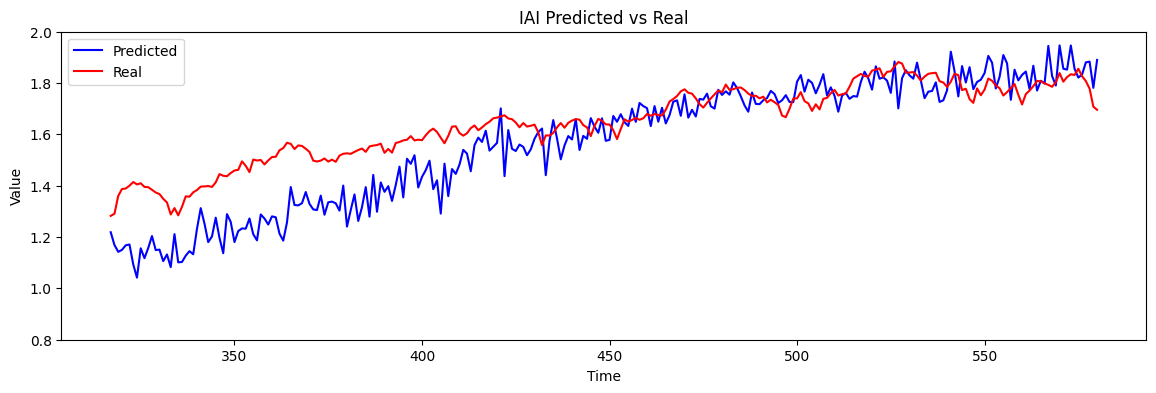

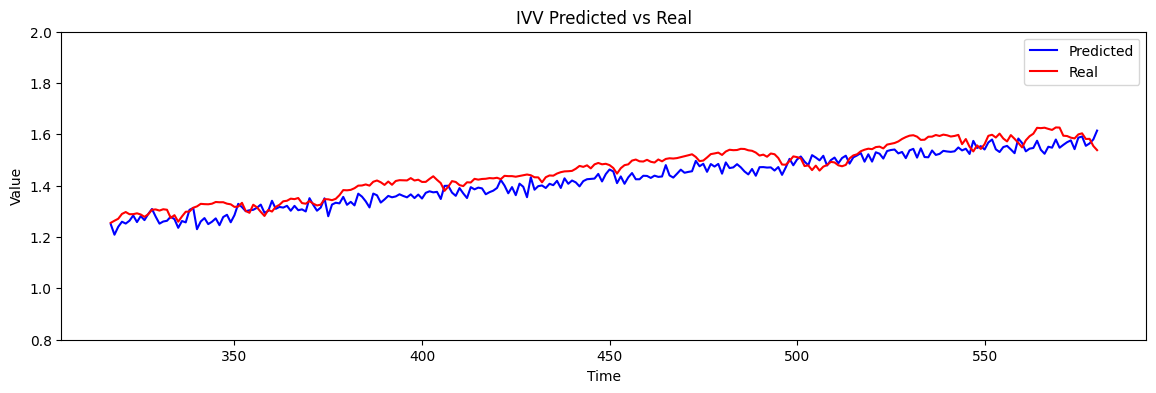

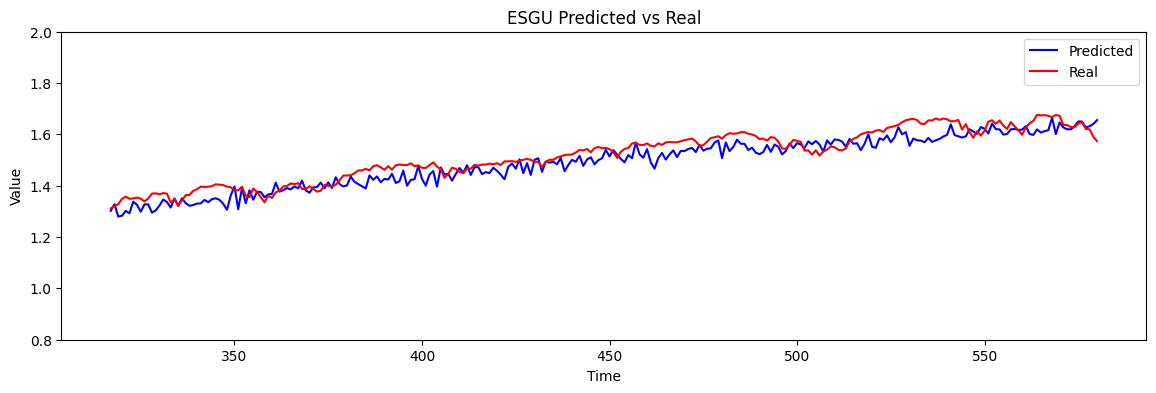

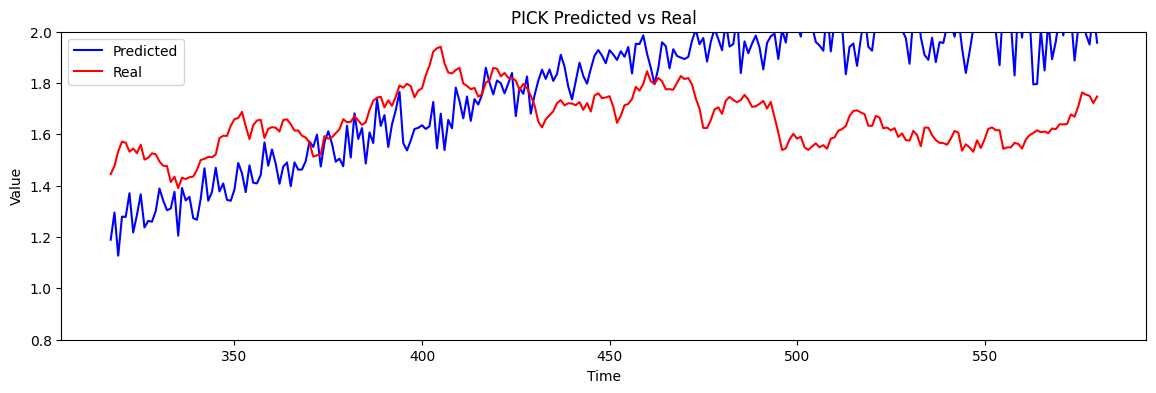

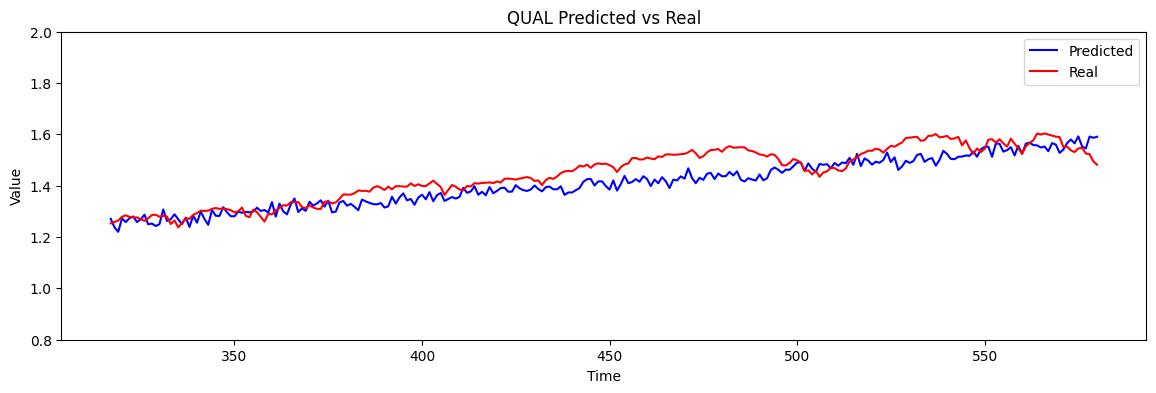

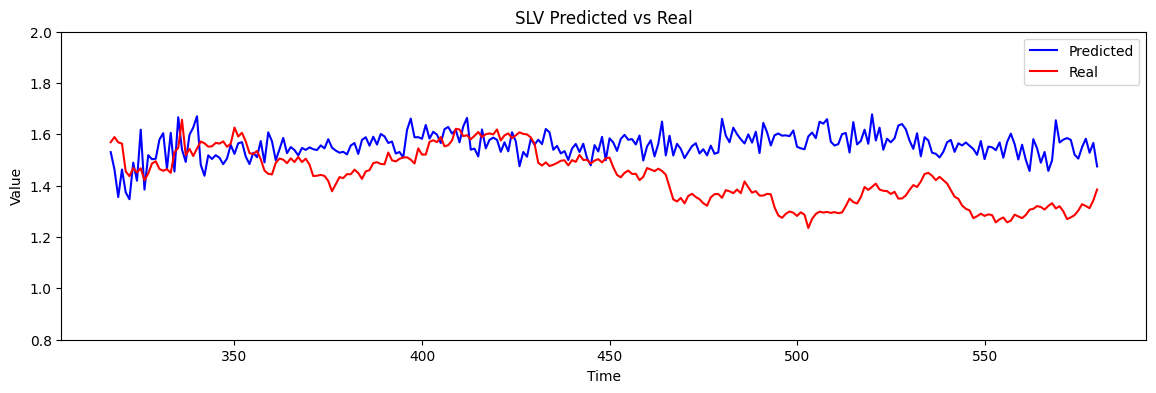

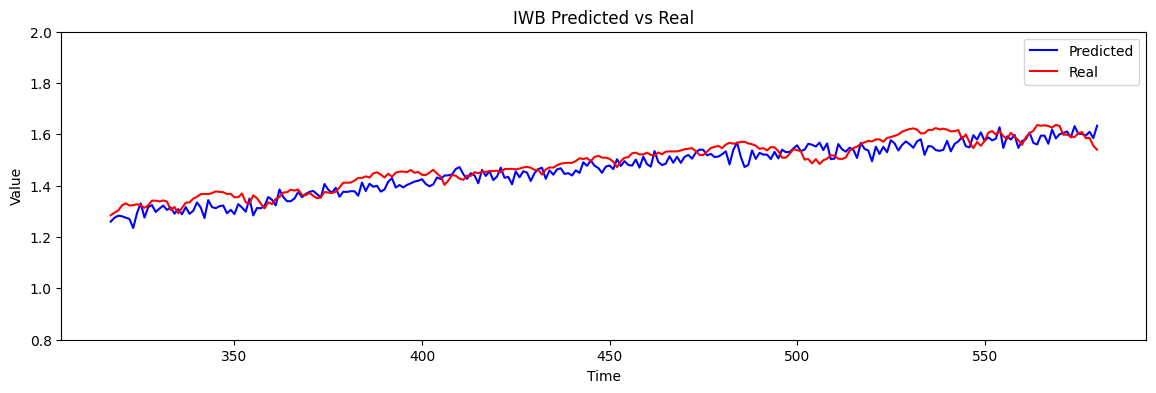

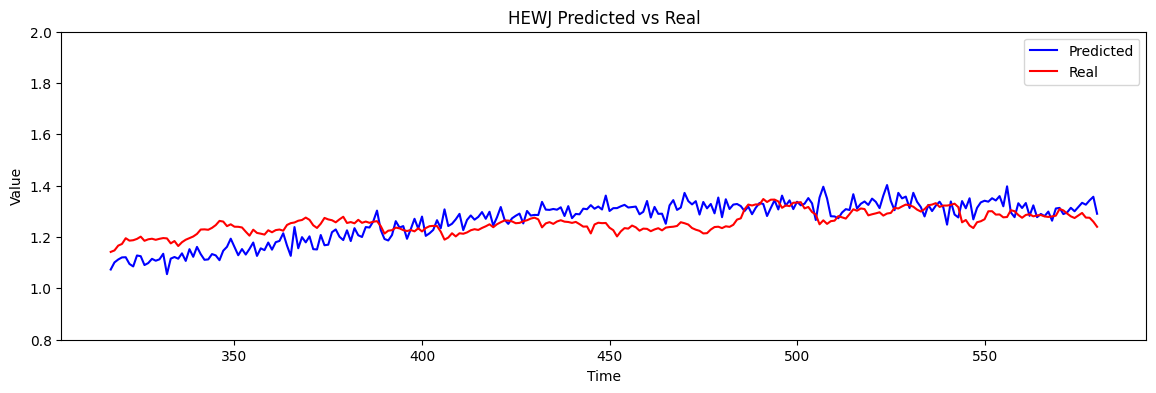

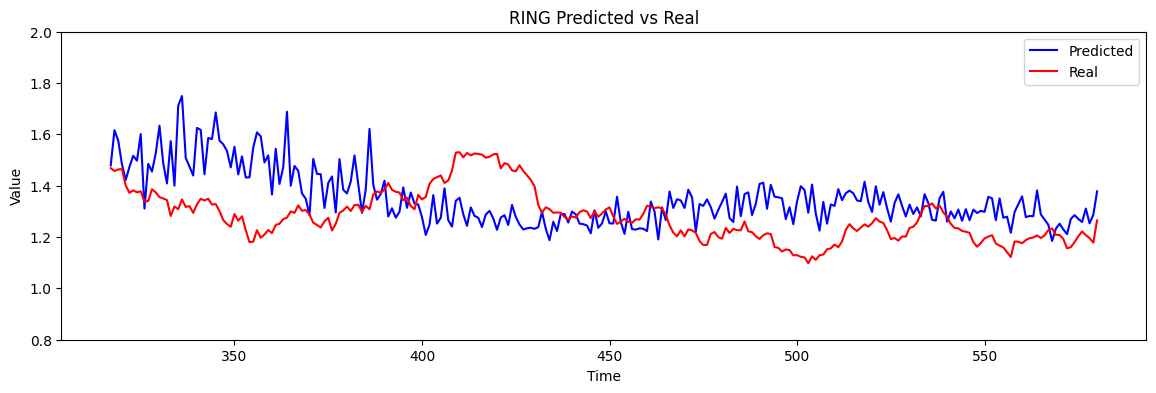

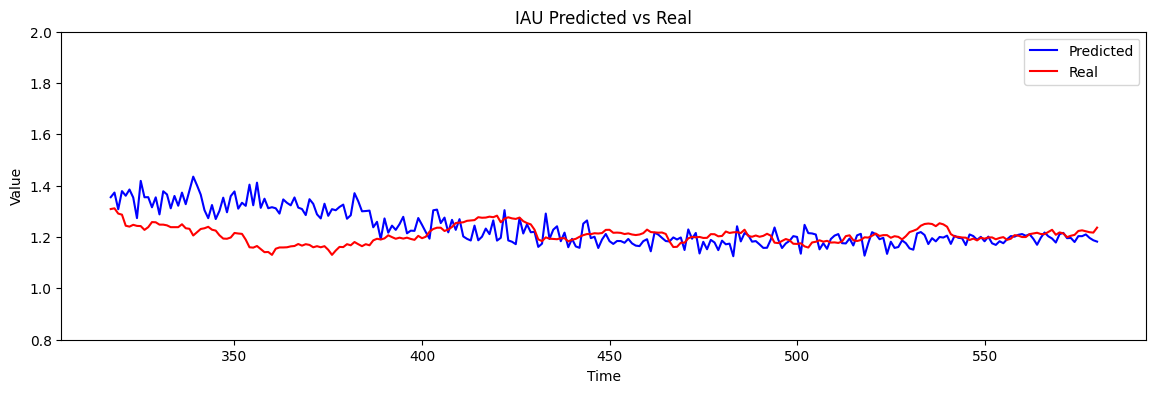

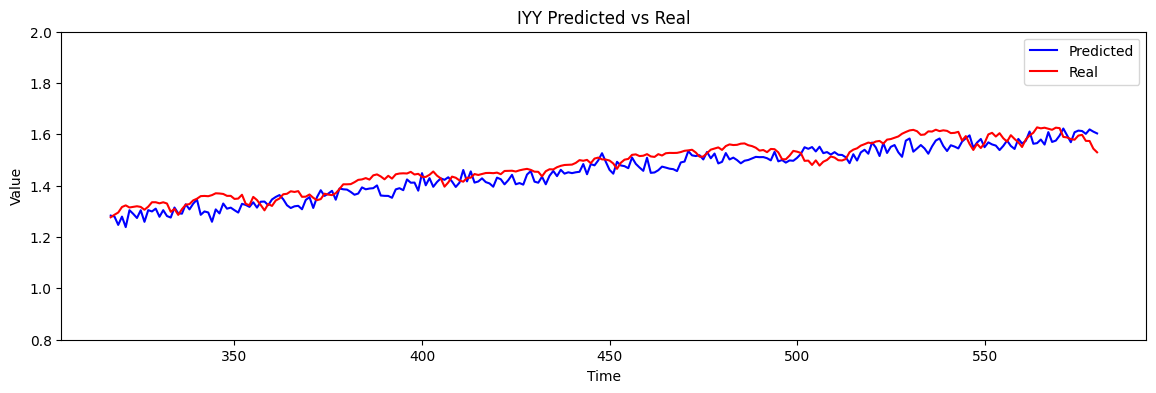

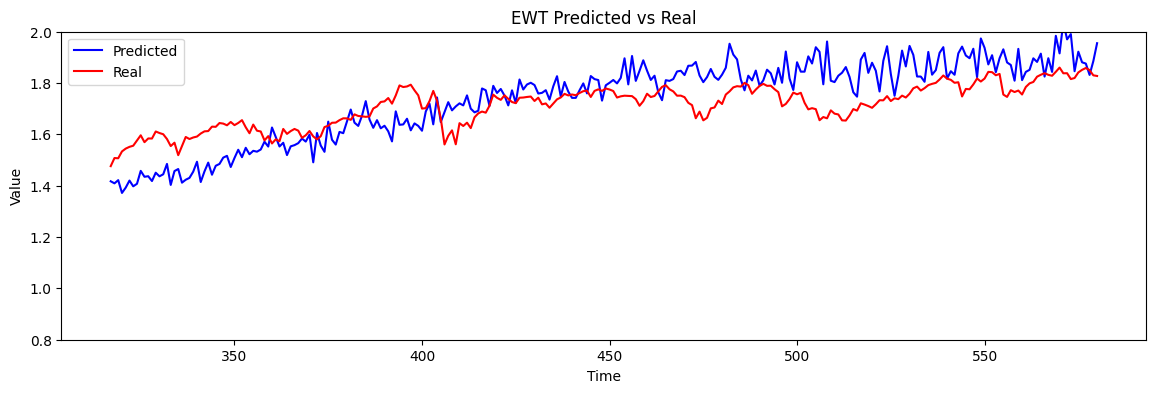

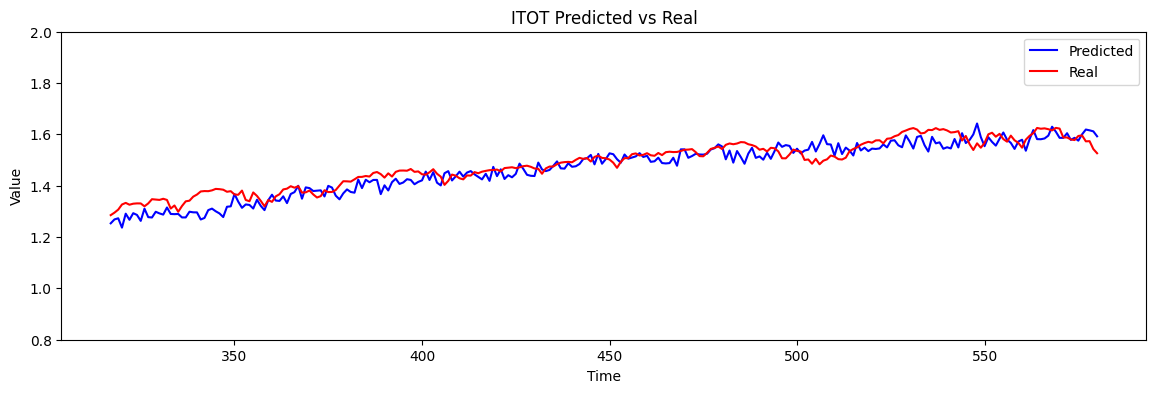

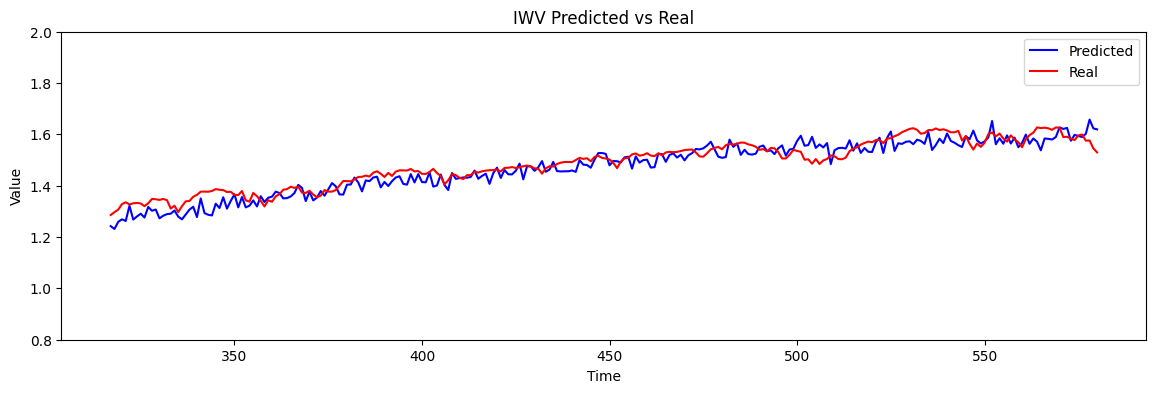

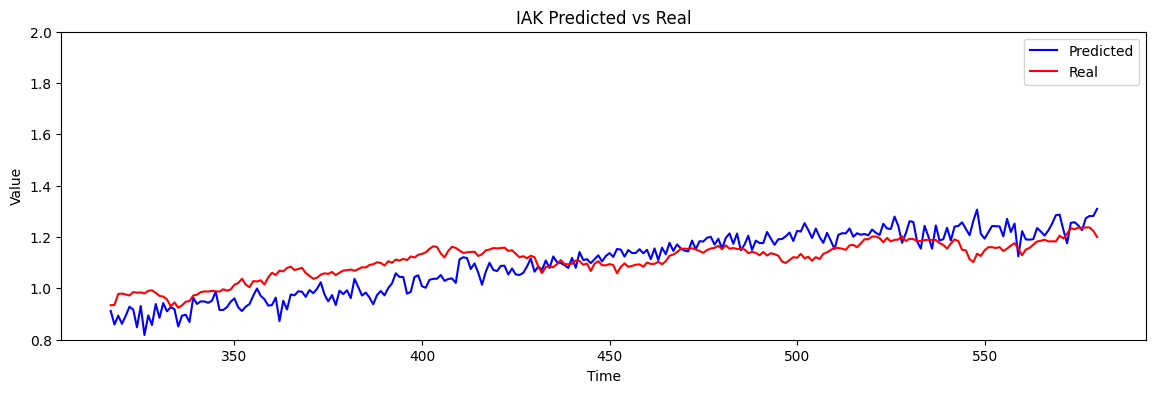

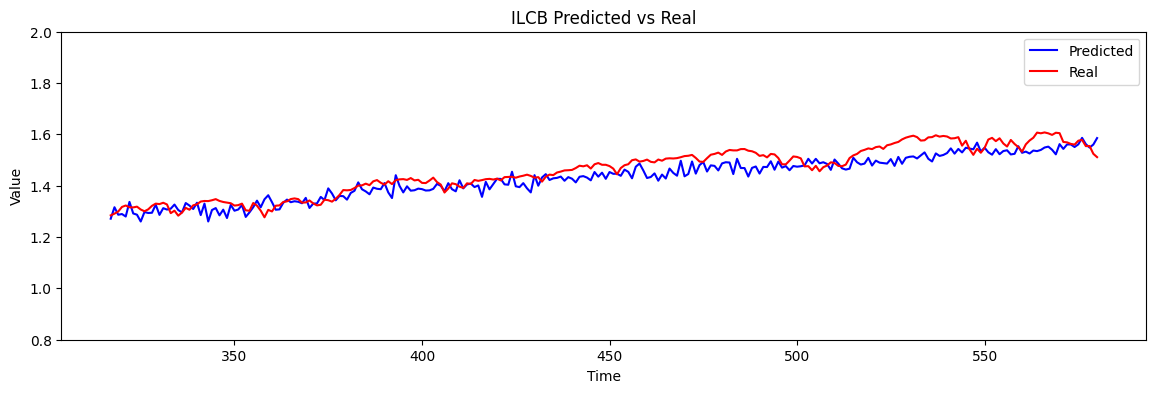

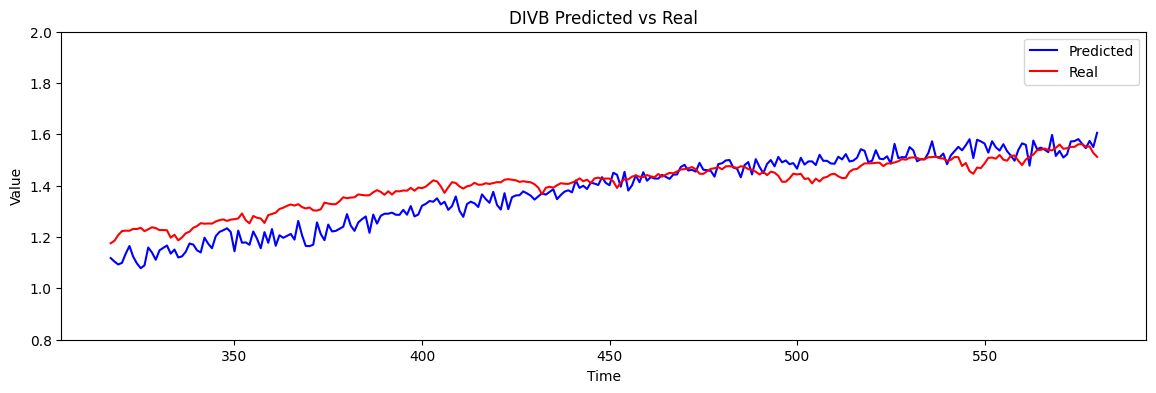

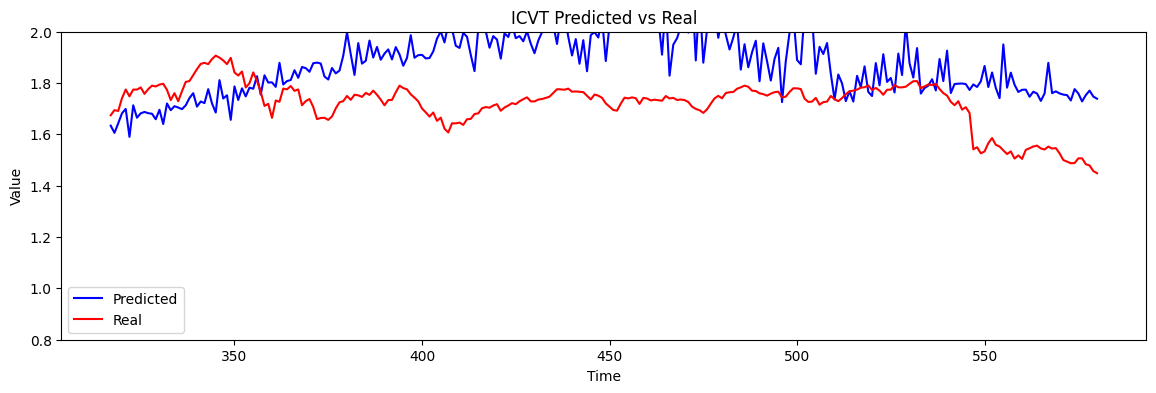

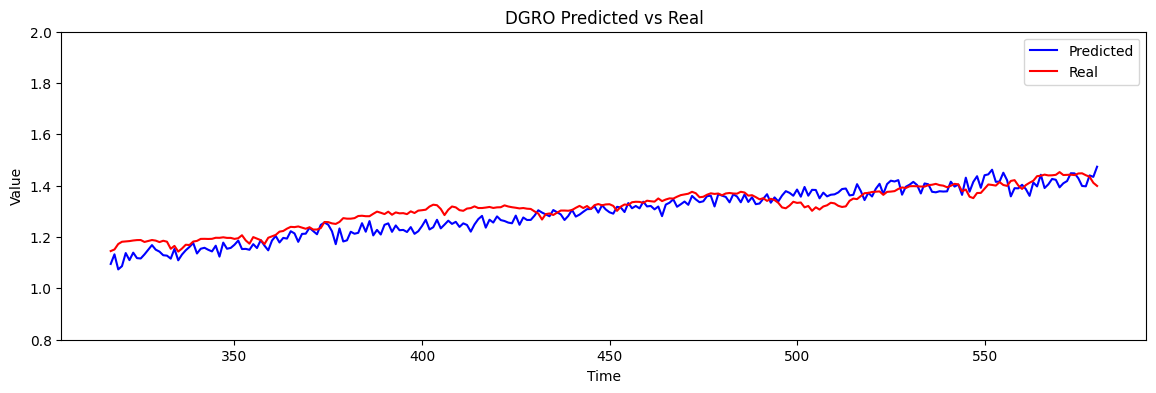

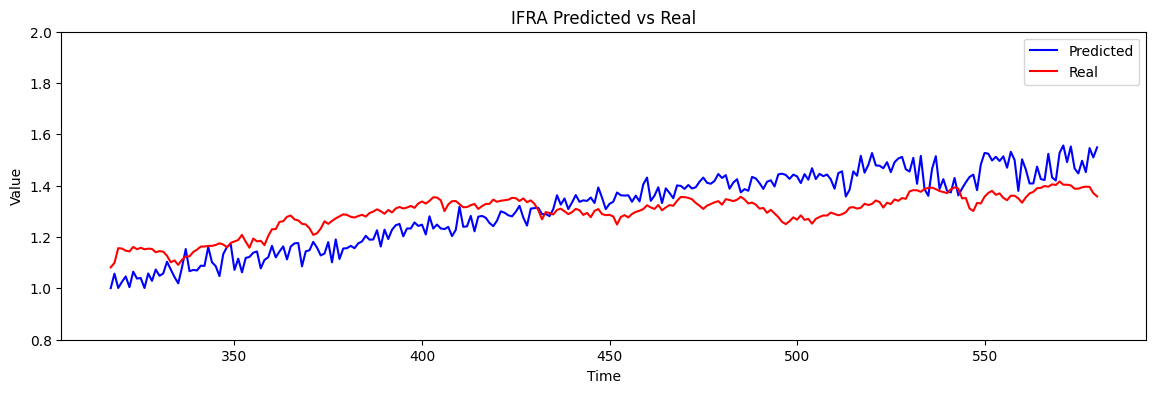

In [5]:
for ticker in tickers: 
    start_date = '2019-10-01'
    end_date = '2021-01-01'
    print(ticker)
    RES = pd.DataFrame()   
    for i in range(11):    
        # history : 2019-10-01 ~ 2022-01-01 的数据
        history = pd.read_csv(f'data\{ticker}.csv')
        history['date'] = pd.to_datetime(history['date'])

        # data : Warming Up 期间的数据
        data = history[(history['date'] >= start_date) 
                    & (history['date'] <= end_date)]
        df = data[["Return"]]
        #df.plot(figsize=(15,5), title="Closing Price of Asset")
        df = df.reset_index(drop=True)
        #df.plot(figsize=(15,5), title = 'Daily percentage change (Daily Return)')
        df_norm = df.to_numpy()
        num_epoch = 200
        config = dict(
            batch_size= 64,
            kernel_size= 21,
            learning_rate= 0.0001,
            seq_len= 96,
            pred_len= 24,
        )
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        data_set = Dataset_Custom(
                df=df_norm,
                seq_len=config['seq_len'],
                pred_len=config['pred_len']
                )

        data_loader = DataLoader(
                data_set,
                batch_size=config['batch_size'],
                shuffle=True,
                drop_last=False)

        model = DLinear(seq_len=config['seq_len'],
                        pred_len=config['pred_len'],
                        kernel_size=config['kernel_size']
                        ).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        criterion = nn.L1Loss().to(device)

        train_loss_ep = []
        for epoch in tqdm(range(num_epoch)):
            train_loss = []

            model.train()
            for i, (batch_x, batch_y) in enumerate(data_loader):
                
                batch_x = batch_x.float().to(device)
                batch_y = batch_y.float().to(device)

                outputs = model(batch_x)


                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                #log
                train_loss.append(loss.item())

            train_loss_ep.append(np.average(train_loss))

            #print(f"Epoch: {epoch+1}/{num_epoch}, Training Loss: {np.average(train_loss)}")
        #pd.DataFrame(train_loss_ep).plot()
        r = df_norm[-config['seq_len']:,:]
        x = torch.tensor(r[-config['seq_len']:,:]).unsqueeze(0)
        model.eval()
        with torch.no_grad():
            output = model(x.float().to(device))
        r = np.append(r, output.squeeze(0).to("cpu").detach().numpy(), axis=0)
        res_df = pd.DataFrame(r[-24:])
        res_df.columns = ["ret_pred"]
        #res_df.plot(figsize=(15,5))
        if RES.empty:
            RES = res_df
        else :
            RES = pd.concat([RES,res_df],axis = 0, ignore_index = True)
        start_date = shift_date_24(start_date, 24)
        end_date = shift_date_24(end_date, 24)
        reset_weights(model)
    
    
    REAL = history[(history['date'] >= '2021-01-04') 
                & (history['date'] <= '2022-01-19')]
    print(f'{ticker}:{REAL.head()}')
    REAL['pred'] = RES.values

    # 假设 pred 和 real 是你的两个时间序列数据

    # 创建一个新的图形
    plt.figure(figsize=(14, 4))

    # 绘制 pred 数据
    plt.plot(REAL['pred'], label='Predicted', color='blue')

    # 绘制 real 数据
    plt.plot(REAL['Return'], label='Real', color='red')

    # 添加标题和标签
    plt.title(f'{ticker} Predicted vs Real')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.ylim(0.8, 2.0)
    # 添加图例
    plt.legend()

    # 显示图形
    plt.savefig(f'image\{rdseed}_{ticker}png', dpi=300)

    REAL.to_csv(f'res\{rdseed}_{ticker}pred.csv', index =False)